In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler

In [2]:
df_ercot = pd.read_csv("load_ercot_regions.csv")
df_ercot['ds']= pd.to_datetime(df_ercot['ds'])
df_ercot

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32
...,...,...,...,...,...,...,...,...,...
154849,2021-08-31 20:00:00,14477.26,1594.07,4307.99,832.71,13920.14,3666.45,7113.79,1150.02
154850,2021-08-31 21:00:00,14044.85,1565.64,4252.85,799.24,13308.33,3503.66,6805.93,1112.36
154851,2021-08-31 22:00:00,13796.10,1519.51,4213.14,777.39,12938.13,3396.58,6611.26,1086.27
154852,2021-08-31 23:00:00,13746.95,1498.90,4188.78,768.89,12876.06,3340.30,6589.14,1075.76


In [3]:
df_ercot.set_index('ds',inplace=True)
df_ercot=df_ercot.asfreq('1H')
df_ercot

,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
ds,,,,,,,,
2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32
...,...,...,...,...,...,...,...,...
2021-08-31 20:00:00,14477.26,1594.07,4307.99,832.71,13920.14,3666.45,7113.79,1150.02
2021-08-31 21:00:00,14044.85,1565.64,4252.85,799.24,13308.33,3503.66,6805.93,1112.36
2021-08-31 22:00:00,13796.10,1519.51,4213.14,777.39,12938.13,3396.58,6611.26,1086.27


In [4]:
# df_ercot = df_ercot.iloc[-10000:,:]

In [5]:
n_unit_size = 24
n_input_chunk = n_unit_size*20
n_output_chunk = n_unit_size*1
n_valid =  n_unit_size*60
n_test = n_unit_size*60
valid_iloc =n_input_chunk+n_valid+n_test
test_iloc = n_input_chunk+n_test

train_ts_list = [TimeSeries.from_series(df_ercot[col].iloc[:-valid_iloc],
                                        fill_missing_dates=False,fillna_value=0) for col in df_ercot.columns]
# valid_ts_list = [TimeSeries.from_series(df_ercot[col].iloc[-valid_iloc:-test_iloc],
#                                         fill_missing_dates=False,fillna_value=0) for col in df_ercot.columns]
test_ts_list = [TimeSeries.from_series(df_ercot[col].iloc[-test_iloc:],
                                       fill_missing_dates=False,fillna_value=0) for col in df_ercot.columns]

train_val_list = [TimeSeries.from_series(df_ercot[col].iloc[:-n_test],
                                       fill_missing_dates=False,fillna_value=0) for col in df_ercot.columns]
all_list = [TimeSeries.from_series(df_ercot[col],
                                       fill_missing_dates=False,fillna_value=0) for col in df_ercot.columns]

In [6]:
# train_ts_list

## 对不同地区进行建模

In [7]:
diqu = 2


scaler = MinMaxScaler()
scaler_list = [Scaler(scaler) for col in df_ercot.columns]
train_ts_list_scaled = [s.fit_transform(t) for s,t in zip(scaler_list,train_ts_list)]
# valid_ts_list_scaled = [s.transform(v) for s,v in zip(scaler_list,valid_ts_list)]
test_ts_list_scaled = [s.transform(v) for s,v in zip(scaler_list,test_ts_list)]
train_val_list_scaled = [s.transform(v) for s,v in zip(scaler_list,train_val_list)]
all_ts_list_scaled = [s.transform(v) for s,v in zip(scaler_list,all_list)]


train_ts_list_scaled = train_ts_list_scaled[diqu]
# valid_ts_list_scaled = valid_ts_list_scaled[0]
test_ts_list_scaled = test_ts_list_scaled[diqu]
train_val_list_scaled = train_val_list_scaled[diqu]
all_ts_list_scaled = all_ts_list_scaled[diqu]

In [8]:
train_val_list_scaled.pd_series()

ds
2004-01-01 01:00:00    0.235397
2004-01-01 02:00:00    0.232502
2004-01-01 03:00:00    0.230037
2004-01-01 04:00:00    0.228755
2004-01-01 05:00:00    0.227478
                         ...   
2021-07-02 20:00:00    0.937231
2021-07-02 21:00:00    0.925974
2021-07-02 22:00:00    0.914642
2021-07-02 23:00:00    0.910283
2021-07-03 00:00:00    0.909844
Freq: H, Length: 153432, dtype: float64

## 确定pdq参数

In [9]:
# from pmdarima import auto_arima

In [10]:

# fittedmodel = auto_arima(train_val_list_scaled.pd_series(), start_p=1, start_q=1, max_p=9, max_q=6, max_d=3,max_order=None,
#                          seasonal=False, m=1, test='adf', trace=False,
#                          error_action='ignore',  # don't want to know if an order does not work
#                          suppress_warnings=True,  # don't want convergence warnings
#                          stepwise=True, information_criterion='bic', njob=-1)  # set to stepwise

In [11]:
# train_ts_list_scaled

## 开始建模

In [12]:
from darts.models import ARIMA,AutoARIMA



pl_trainer_kwargs={
     "accelerator": "gpu",
      "gpus": 1


    }


[2022-05-24 09:54:11,512] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).
2022-05-24 09:54:11 darts.models WARNING: Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


In [13]:
# model = RandomForest(pl_trainer_kwargs=pl_trainer_kwargs,
#                  input_chunk_length=n_input_chunk,
#                  training_length=n_input_chunk+n_output_chunk, n_rnn_layers=2
#                 )

# model = AutoARIMA(start_p=1,start_q=1,max_p=3,max_q=3,m=12,
#                 start_P=0,seasonal=True,d=1,D=1,trace = True,
#                 error_action ='ignore',suppress_warnings = True,stepwise=True)

# model.fit(train_val_list_scaled)
# model = ARIMA(24,1,24,[2,1,2,12])
model = ARIMA(24,2,24)

In [14]:
# train = scaler_list[0].transform(df_ercot[0].iloc[:-test_iloc])
# model.fit(train_ts_list_scaled,val_series=valid_ts_list_scaled,verbose=True,epochs=1,trainer=None)
model.fit(train_val_list_scaled[-10000:])
#  ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=12.85 sec
#  ARIMA(0,1,0)(0,1,0)[12]             : AIC=-33996.392, Time=0.62 sec
#  ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=12.10 sec
#  ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=10.62 sec
#  ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=2.60 sec
#  ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=6.53 sec
#  ARIMA(0,1,0)(1,1,1)[12]             : AIC=-56980.450, Time=6.81 sec
#  ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=18.82 sec
#  ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=26.20 sec
#  ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=13.87 sec
#  ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=3.51 sec
#  ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=27.31 sec
#  ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=17.29 sec
#  ARIMA(0,1,1)(1,1,1)[12]             : AIC=-57354.179, Time=14.80 sec
#  ARIMA(0,1,1)(1,1,0)[12]             : AIC=-57066.219, Time=5.10 sec
#  ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=24.55 sec
#  ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=36.75 sec
#  ARIMA(0,1,1)(0,1,0)[12]             : AIC=-40831.585, Time=1.65 sec
#  ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=22.09 sec
#  ARIMA(0,1,1)(2,1,0)[12]             : AIC=-57103.398, Time=15.76 sec
#  ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=31.97 sec
#  ARIMA(1,1,1)(1,1,1)[12]             : AIC=-57587.167, Time=15.72 sec

D:\aaruanjian\Anaconda\insatll_anaconda\envs\darts_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
pred = model.historical_forecasts( test_ts_list_scaled,verbose=False,retrain=True,
                                  start=n_input_chunk,forecast_horizon=2*n_output_chunk,stride=2*n_output_chunk,
                                  overlap_end=True,last_points_only =False)
pred_df = pd.concat([pred[s].pd_series() for s in range(len(pred))])

D:\aaruanjian\Anaconda\insatll_anaconda\envs\darts_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\aaruanjian\Anaconda\insatll_anaconda\envs\darts_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\aaruanjian\Anaconda\insatll_anaconda\envs\darts_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\aaruanjian\Anaconda\insatll_anaconda\envs\darts_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

In [16]:


# pred = model.predict(n_test)

In [17]:
# pred


In [18]:
# pred_df = pd.concat([pred[s].pd_series() for s in range(len(pred))])

In [19]:
pred_df

ds
2021-07-03 01:00:00    0.912920
2021-07-03 02:00:00    0.916411
2021-07-03 03:00:00    0.924083
2021-07-03 04:00:00    0.931651
2021-07-03 05:00:00    0.941659
                         ...   
2021-08-31 20:00:00    0.986522
2021-08-31 21:00:00    0.970514
2021-08-31 22:00:00    0.956401
2021-08-31 23:00:00    0.948258
2021-09-01 00:00:00    0.948421
Freq: H, Length: 1440, dtype: float64

In [20]:
test_df = pd.concat([pred_df,test_ts_list_scaled.pd_series()],axis=1).iloc[n_input_chunk:,:]
test_df.columns = [f'yhat',f'y']
# test_all_df = pd.concat([test_all_df,test_df],axis=1)

In [21]:
test_df

,yhat,y
ds,,
2021-07-03 01:00:00,0.912920,0.914417
2021-07-03 02:00:00,0.916411,0.915794
2021-07-03 03:00:00,0.924083,0.929876
2021-07-03 04:00:00,0.931651,0.953015
2021-07-03 05:00:00,0.941659,0.978947
...,...,...
2021-08-31 20:00:00,0.986522,0.970519
2021-08-31 21:00:00,0.970514,0.958097
2021-08-31 22:00:00,0.956401,0.949151


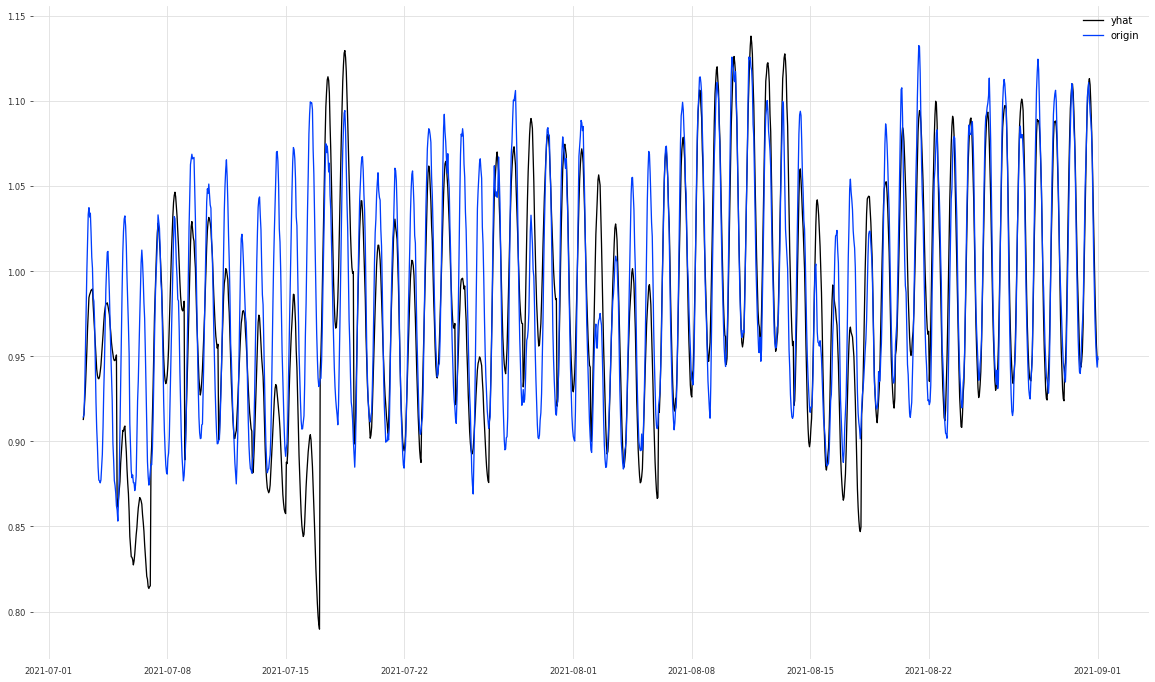

In [22]:
plt.figure(figsize=(20,12))
plt.plot(test_df.index,test_df.yhat,label='yhat')
plt.plot(test_df.index,test_df.y,label='origin')
plt.legend()

In [23]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
MSE = mean_squared_error(test_df.y, test_df.yhat)
MAE = mean_absolute_error(test_df.y, test_df.yhat)
MAPE = mean_absolute_percentage_error(test_df.y, test_df.yhat)
print(df_ercot.columns[diqu])
print("MSE=",MSE)
print("MAE=",MAE)
print("MAPE=",MAPE)

FAR_WEST
MSE= 0.0019311448908237987
MAE= 0.03076889521178206
MAPE= 0.03121776744589708


In [24]:
data = pd.read_csv("../融合模型/final_result.csv",index_col=0)
data

,ds,y,prophet,TCN,RNN,LSTM,ARIMA,GRU,TCN-Prophet
0,2021/7/3 1:00,0.597219,0.610797,0.580292,0.603026,0.603009,0.600584,0.604435,0.607891
1,2021/7/3 2:00,0.618928,0.642740,0.597894,0.626438,0.624958,0.623070,0.628965,0.638468
2,2021/7/3 3:00,0.663583,0.679314,0.634995,0.657364,0.653864,0.661592,0.660048,0.675092
3,2021/7/3 4:00,0.717383,0.708772,0.673650,0.694046,0.688473,0.702041,0.695185,0.705426
4,2021/7/3 5:00,0.771838,0.744462,0.713423,0.733624,0.726427,0.739611,0.731576,0.741505
...,...,...,...,...,...,...,...,...,...
1435,2021/8/31 20:00,0.681087,0.688483,0.634238,0.611561,0.591231,0.580097,0.625666,0.683316
1436,2021/8/31 21:00,0.660744,0.661254,0.619213,0.596926,0.566846,0.557350,0.607854,0.657249
1437,2021/8/31 22:00,0.649041,0.661117,0.614370,0.589256,0.550675,0.539509,0.596848,0.656663
1438,2021/8/31 23:00,0.646729,0.664052,0.616129,0.589428,0.543591,0.530948,0.593612,0.659486


In [25]:
data["ARIMA"] = test_df["yhat"].values
data

,ds,y,prophet,TCN,RNN,LSTM,ARIMA,GRU,TCN-Prophet
0,2021/7/3 1:00,0.597219,0.610797,0.580292,0.603026,0.603009,0.912920,0.604435,0.607891
1,2021/7/3 2:00,0.618928,0.642740,0.597894,0.626438,0.624958,0.916411,0.628965,0.638468
2,2021/7/3 3:00,0.663583,0.679314,0.634995,0.657364,0.653864,0.924083,0.660048,0.675092
3,2021/7/3 4:00,0.717383,0.708772,0.673650,0.694046,0.688473,0.931651,0.695185,0.705426
4,2021/7/3 5:00,0.771838,0.744462,0.713423,0.733624,0.726427,0.941659,0.731576,0.741505
...,...,...,...,...,...,...,...,...,...
1435,2021/8/31 20:00,0.681087,0.688483,0.634238,0.611561,0.591231,0.986522,0.625666,0.683316
1436,2021/8/31 21:00,0.660744,0.661254,0.619213,0.596926,0.566846,0.970514,0.607854,0.657249
1437,2021/8/31 22:00,0.649041,0.661117,0.614370,0.589256,0.550675,0.956401,0.596848,0.656663
1438,2021/8/31 23:00,0.646729,0.664052,0.616129,0.589428,0.543591,0.948258,0.593612,0.659486


In [26]:
# data.to_csv("../融合模型/final_result.csv")